In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

/var/folders/kt/026ybdfj1nx440kk4b1nbgjw0000gn/T/ipykernel_5894/2722183799.py:4: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



In [2]:
df = pd.read_csv('data/receipt.csv')
df["amount_randomise"] = df["amount"] + np.random.randint(-50, 50, df.shape[0])
df["amount_randomise"] = df["amount_randomise"].where(df["amount_randomise"] > 0, 0)
display(df.head())
df.describe()

,sales_ymd,sales_epoch,store_cd,receipt_no,receipt_sub_no,customer_id,product_cd,quantity,amount,amount_randomise
0,20181103,1541203200,S14006,112,1,CS006214000001,P070305012,1,158,196
1,20181118,1542499200,S13008,1132,2,CS008415000097,P070701017,1,81,79
2,20170712,1499817600,S14028,1102,1,CS028414000014,P060101005,1,170,176
3,20190205,1549324800,S14042,1132,1,ZZ000000000000,P050301001,1,25,0
4,20180821,1534809600,S14025,1102,2,CS025415000050,P060102007,1,90,58


,sales_ymd,sales_epoch,receipt_no,receipt_sub_no,quantity,amount,amount_randomise
count,1.046810e+05,1.046810e+05,104681.000000,104681.000000,104681.000000,104681.000000,104681.000000
mean,2.018063e+07,1.529803e+09,1053.543699,1.500855,1.011282,320.560083,320.018246
std,8.012852e+03,2.580916e+07,298.326621,0.500002,0.114136,477.702749,478.567801
min,2.017010e+07,1.483229e+09,112.000000,1.000000,1.000000,10.000000,0.000000
25%,2.017101e+07,1.507680e+09,1112.000000,1.000000,1.000000,102.000000,110.000000
50%,2.018070e+07,1.530749e+09,1142.000000,2.000000,1.000000,170.000000,172.000000
75%,2.019031e+07,1.552349e+09,1172.000000,2.000000,1.000000,288.000000,291.000000
max,2.019103e+07,1.572480e+09,1664.000000,2.000000,8.000000,10925.000000,10922.000000


In [13]:
df1 = df.copy()
# 日付データに生計
df1["sales_ymd"] = pd.to_datetime(df1["sales_ymd"], format="%Y%m%d")
df1 = df1.set_index("sales_ymd")

use_store_lst = ["S13018", "S13019", "S14010"]
df1 = df1.query("store_cd in @use_store_lst")


df1_day = (df1[["store_cd", "quantity", "amount", "amount_randomise"]]
             .groupby("store_cd")
             .resample("D", origin='start_day')
             .sum()
             .reset_index()
             )
df1_week = (df1[["store_cd", "quantity", "amount", "amount_randomise"]]
             .groupby("store_cd")
             .resample("W-MON", origin='start_day', closed="left", label='left') # label:入れる日付は最初か最後か closed:閉区間はどちらか
             .sum()
             .reset_index()
             )
df1_month = (df1[["store_cd", "quantity", "amount", "amount_randomise"]]
             .groupby("store_cd")
             .resample("MS", origin='start_day') # Mだと各月の最終日に出力
             .sum()
             .reset_index()
             )

df1_year = (df1[["store_cd", "quantity", "amount", "amount_randomise"]]
             .groupby("store_cd")
             .resample("YS", origin='start_day') # Mだと各月の最終日に出力
             .sum()
             .reset_index()
             )

df1_day

,store_cd,sales_ymd,quantity,amount,amount_randomise
0,S13018,2017-01-01,4,746,660
1,S13018,2017-01-02,4,718,710
2,S13018,2017-01-03,5,1552,1516
3,S13018,2017-01-04,0,0,0
4,S13018,2017-01-05,2,698,694
...,...,...,...,...,...
3097,S14010,2019-10-27,4,5414,5335
3098,S14010,2019-10-28,0,0,0
3099,S14010,2019-10-29,0,0,0
3100,S14010,2019-10-30,0,0,0


In [14]:
df1_w_melt = (df1_week.reset_index()
                     .melt(id_vars=["sales_ymd","store_cd"],
                            value_vars=["quantity","amount","amount_randomise"],
                            var_name="index",
                            value_name="value"))
df1_w_melt

,sales_ymd,store_cd,index,value
0,2016-12-26,S13018,quantity,4
1,2017-01-02,S13018,quantity,20
2,2017-01-09,S13018,quantity,12
3,2017-01-16,S13018,quantity,20
4,2017-01-23,S13018,quantity,19
...,...,...,...,...
1336,2019-09-30,S14010,amount_randomise,5347
1337,2019-10-07,S14010,amount_randomise,6278
1338,2019-10-14,S14010,amount_randomise,7864
1339,2019-10-21,S14010,amount_randomise,8378


In [28]:
fig = px.line(df1_w_melt,
              x="sales_ymd",
              y="value",
              color='index',
              facet_row="store_cd",
              hover_data="store_cd"
              )

# Add range slider
fig.update_layout(
    # xaxis=dict(
    #     rangeslider=dict(
    #         visible=True,
    #     ),
    #     type="date",
    # )
)

# fig.update_layout(legend=dict(
#     orientation="h",
#     yanchor="bottom",
#     y=1.02,
#     xanchor="left",
#     x=0
# ))

fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    height=1000,
    paper_bgcolor="LightSteelBlue",
)

fig.show()

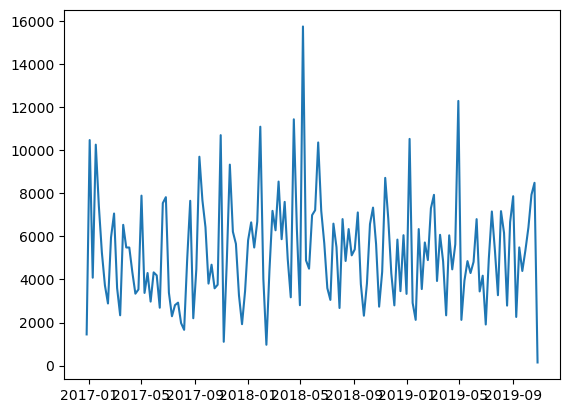

In [23]:
df1_w_melt

use_store = "S14010"
use_index = "amount"

df1_w_melt_use = df1_w_melt.query("store_cd == @use_store and index == @use_index")

plt.plot(df1_w_melt_use["sales_ymd"],df1_w_melt_use["value"])

In [29]:
dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    )

{'bgcolor': 'white', 'font_size': 16, 'font_family': 'Rockwell'}